# CUSTOMER SEGMENTATION AND RECOMMENDATIONS

1.1  Importing Necessary Libraries

In [132]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
%matplotlib inline

In [133]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [134]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#e0dcfc'}, style='darkgrid')

1.2  Loading the Dataset

In [135]:
#: Set the path
path = "online_retail.xlsx"
#: Read the file
df = pd.read_excel(path)

2 | Initial Data Analysis

2.1  Dataset Overview

In [136]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


2.2  Summary Statistics

In [138]:
# Summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,525461.0,10.337667,107.424110,-9600.00,1.00,3.0,10.00,19152.00
Price,525461.0,4.688834,146.126914,-53594.36,1.25,2.1,4.21,25111.09
Customer ID,417534.0,15360.645478,1680.811316,12346.00,13983.00,15311.0,16799.00,18287.00


In [139]:
# Summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
Invoice,525461,28816,537434,675
StockCode,525461,4632,85123A,3516
Description,522533,4681,WHITE HANGING HEART T-LIGHT HOLDER,3549
Country,525461,40,United Kingdom,485852


3 |  Data Cleaning & Transformation

3.1  Handling Missing Values

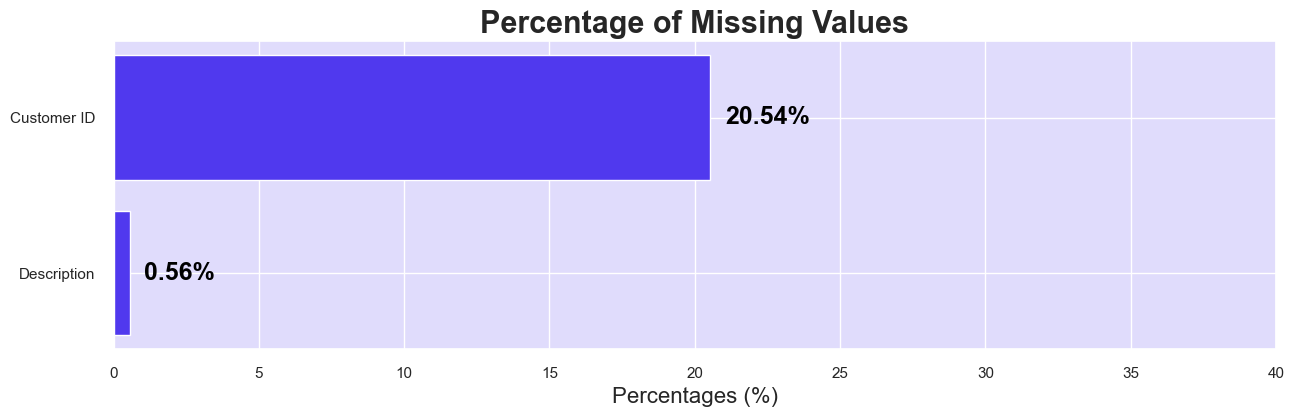

In [140]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Prepare values
missing_percentage.sort_values(ascending=True, inplace=True)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#5039ee')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 40])

# Add title and xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [141]:
# Extracting rows with missing values in 'Customer ID' or 'Description' columns
df[df['Customer ID'].isnull() | df['Description'].isnull()].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom


In [142]:
# Removing rows with missing values in 'Customer ID' and 'Description' columns
df = df.dropna(subset=['Customer ID', 'Description'])

In [143]:
# Verifying the removal of missing values
df.isnull().sum().sum()

0

 3.2  Handling Duplicates

In [144]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['Invoice', 'StockCode', 'Description', 'Customer ID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
379,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom
391,489517,21491,SET OF THREE VINTAGE GIFT WRAPS,1,2009-12-01 11:34:00,1.95,16329.0,United Kingdom
365,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
363,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
371,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
394,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
362,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
385,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329.0,United Kingdom
368,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329.0,United Kingdom


In [145]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df.drop_duplicates(inplace=True)

The dataset contains 6771 duplicate rows that need to be removed.


In [146]:
# Getting the number of rows in the dataframe
df.shape[0]

410763

3.3  Treating Cancelled Transactions

In [147]:
# Filter out the rows with Invoice starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['Invoice'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('Customer ID', axis=1)

,Quantity,Price
count,9816.000000,9816.000000
mean,-21.582722,28.529997
std,212.324392,405.514214
min,-9360.000000,0.010000
25%,-6.000000,1.565000
50%,-2.000000,2.950000
75%,-1.000000,6.750000
max,-1.000000,25111.090000


In [148]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.39%


3.4  Correcting StockCode Anomalies

In [149]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()

# Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 4031


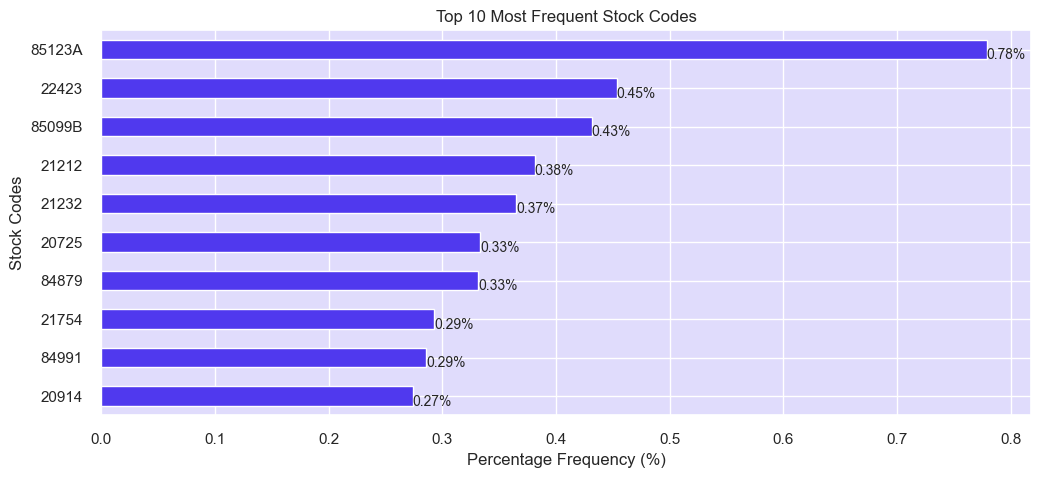

In [150]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#5039ee')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [151]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    4020
0       6
1       2
3       2
4       1
dtype: int64


In [152]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
M
C2
BANK CHARGES
PADS
ADJUST
ADJUST2


In [153]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.44%


In [154]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [155]:
# Getting the number of rows in the dataframe
df.shape[0]

408970

3.5  Cleaning Description Column

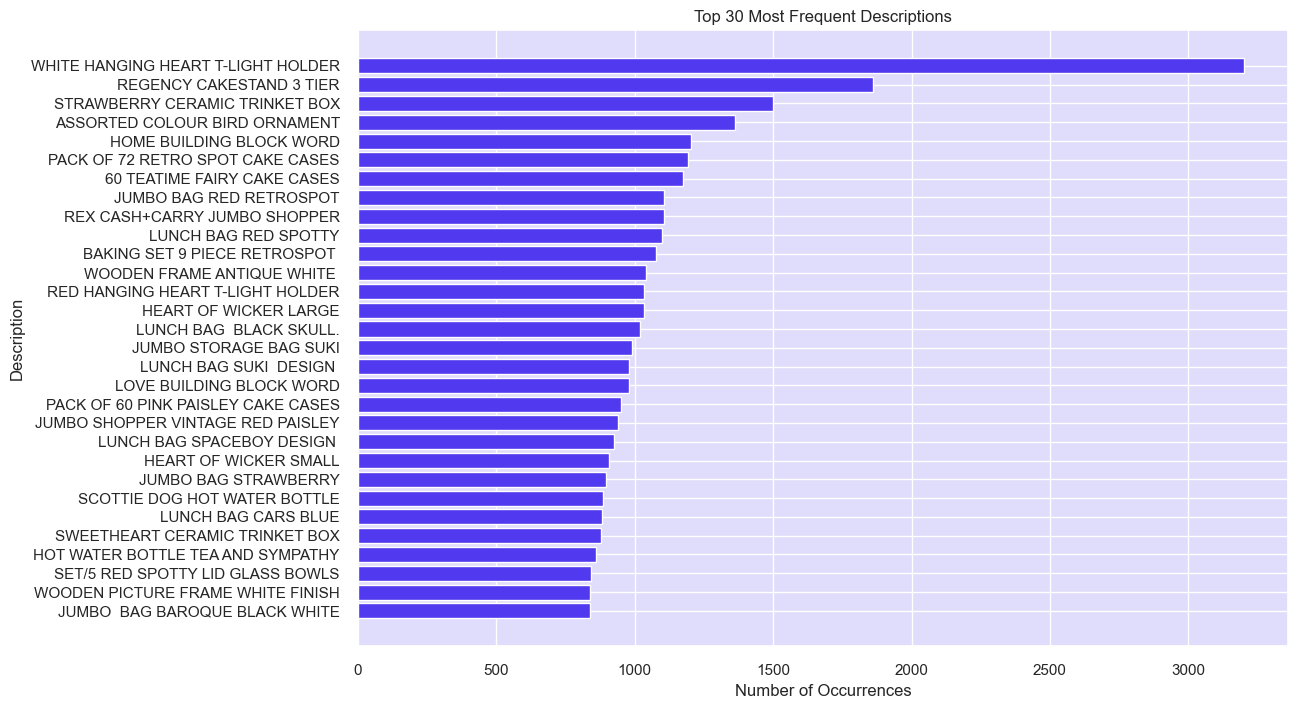

In [156]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#5039ee')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [157]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 40x40cm
POLYESTER FILLER PAD 60x40cm
POLYESTER FILLER PAD 65CMx65CM
POLYESTER FILLER PAD 45x45cm
BAG 125g SWIRLY MARBLES
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
FOLK ART GREETING CARD,pack/12
BAG 250g SWIRLY MARBLES
POLYESTER FILLER PAD 30CMx30CM
This is a test product.
POLYESTER FILLER PAD 45x30cm
 SET Of 6 SOLDIER SKITTLES
THE KING GIFT BAG 25x24x12cm
FRENCH BLUE METAL DOOR SIGN, No
NUMBER TILE COTTAGE GARDEN, No
NUMBER TILE VINTAGE FONT, No 
NUMBER TILE VINTAGE FONT No 
FRENCH BLUE METAL DOOR SIGN No
NUMBER TILE COTTAGE GARDEN No
3 TRADITIONAl BISCUIT CUTTERS  SET


In [158]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Calculate the percentage of records with service-related descriptions
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Remove rows with service-related information in the description
df = df[~df['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.00%


In [159]:
# Getting the number of rows in the dataframe
df.shape[0]

408970

3.6  Treating Zero Unit Prices

In [160]:
df['Price'].describe()

count    408970.000000
mean          3.037837
std           4.498171
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         295.000000
Name: Price, dtype: float64

In [161]:
df[df['Price']==0].describe()[['Quantity']]

,Quantity
count,30.000000
mean,28.966667
std,117.517565
min,1.000000
25%,1.250000
50%,5.000000
75%,9.750000
max,648.000000


In [162]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['Price'] > 0]

3.7  Outlier Treatment

In [163]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

In [164]:
# Getting the number of rows in the dataframe
df.shape[0]

408940

Step 4 | Feature Engineering

4.1  RFM Features

4.1.1  Recency (R)

In [165]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('Customer ID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

In [166]:
customer_data.head()

,Customer ID,Days_Since_Last_Purchase
0,12346.0,66
1,12347.0,2
2,12348.0,73
3,12349.0,42
4,12351.0,10


4.1.2 Frequency (F)

In [167]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('Customer ID')['Invoice'].nunique().reset_index()
total_transactions.rename(columns={'Invoice': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('Customer ID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='Customer ID')
customer_data = pd.merge(customer_data, total_products_purchased, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,66,12,69
1,12347.0,2,2,828
2,12348.0,73,1,372
3,12349.0,42,3,986
4,12351.0,10,1,261


4.1.3 Monetary (M)

In [168]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['Price'] * df['Quantity']
total_spend = df.groupby('Customer ID')['Total_Spend'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='Customer ID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='Customer ID')
customer_data = pd.merge(customer_data, average_transaction_value[['Customer ID', 'Average_Transaction_Value']], on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,66,12,69,368.36,30.696667
1,12347.0,2,2,828,1323.32,661.660000
2,12348.0,73,1,372,221.16,221.160000
3,12349.0,42,3,986,2196.99,732.330000
4,12351.0,10,1,261,300.93,300.930000


4.2  Product Diversity

In [169]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('Customer ID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,66,12,69,368.36,30.696667,26
1,12347.0,2,2,828,1323.32,661.660000,70
2,12348.0,73,1,372,221.16,221.160000,19
3,12349.0,42,3,986,2196.99,732.330000,91
4,12351.0,10,1,261,300.93,300.930000,21


4.3 Behavioral Features

In [170]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('Customer ID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('Customer ID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['Customer ID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('Customer ID')['Count'].idxmax()][['Customer ID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['Customer ID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('Customer ID')['Count'].idxmax()][['Customer ID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='Customer ID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='Customer ID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,66,12,69,368.36,30.696667,26,8.909091,0,13
1,12347.0,2,2,828,1323.32,661.660000,70,0.528571,6,14
2,12348.0,73,1,372,221.16,221.160000,19,0.000000,0,14
3,12349.0,42,3,986,2196.99,732.330000,91,3.153846,3,8
4,12351.0,10,1,261,300.93,300.930000,21,0.000000,0,15


4.4  Geographic Features

In [171]:
df['Country'].value_counts(normalize=True).head()

United Kingdom    0.909388
EIRE              0.020935
Germany           0.019120
France            0.013457
Netherlands       0.006580
Name: Country, dtype: float64

In [172]:
# Group by Customer ID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['Customer ID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('Customer ID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['Customer ID', 'Is_UK']], on='Customer ID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,66,12,69,368.36,30.696667,26,8.909091,0,13,1
1,12347.0,2,2,828,1323.32,661.660000,70,0.528571,6,14,0
2,12348.0,73,1,372,221.16,221.160000,19,0.000000,0,14,0
3,12349.0,42,3,986,2196.99,732.330000,91,3.153846,3,8,0
4,12351.0,10,1,261,300.93,300.930000,21,0.000000,0,15,0


In [173]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

1    3898
0     332
Name: Is_UK, dtype: int64

4.5 Cancellation Insights

In [174]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('Customer ID')['Invoice'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('Customer ID')['Invoice'].nunique().reset_index()
cancellation_frequency.rename(columns={'Invoice': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='Customer ID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['Invoice']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,66,12,69,368.36,30.696667,26,8.909091,0,13,1,1.0,0.083333
1,12347.0,2,2,828,1323.32,661.660000,70,0.528571,6,14,0,0.0,0.000000
2,12348.0,73,1,372,221.16,221.160000,19,0.000000,0,14,0,0.0,0.000000
3,12349.0,42,3,986,2196.99,732.330000,91,3.153846,3,8,0,1.0,0.333333
4,12351.0,10,1,261,300.93,300.930000,21,0.000000,0,15,0,0.0,0.000000


4.6  Seasonality & Trends

In [175]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['Customer ID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('Customer ID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('Customer ID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='Customer ID')
customer_data = pd.merge(customer_data, spending_trends, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,66,12,69,368.36,30.696667,26,8.909091,0,13,1,1.0,0.083333,73.672,60.927253,-18.369
1,12347.0,2,2,828,1323.32,661.660000,70,0.528571,6,14,0,0.0,0.000000,661.660,70.894526,100.260
2,12348.0,73,1,372,221.16,221.160000,19,0.000000,0,14,0,0.0,0.000000,221.160,0.000000,0.000
3,12349.0,42,3,986,2196.99,732.330000,91,3.153846,3,8,0,1.0,0.333333,732.330,656.479014,588.385
4,12351.0,10,1,261,300.93,300.930000,21,0.000000,0,15,0,0.0,0.000000,300.930,0.000000,0.000


In [176]:
# Changing the data type of 'Customer ID' to string as it is a unique identifier and not used in mathematical operations
customer_data['Customer ID'] = customer_data['Customer ID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [177]:
customer_data.head(10)

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,66,12,69,368.36,30.696667,26,8.909091,0,13,1,1,0.083333,73.672,60.927253,-18.369
1,12347.0,2,2,828,1323.32,661.66,70,0.528571,6,14,0,0,0.0,661.66,70.894526,100.26
2,12348.0,73,1,372,221.16,221.16,19,0.0,0,14,0,0,0.0,221.16,0.0,0.0
3,12349.0,42,3,986,2196.99,732.33,91,3.153846,3,8,0,1,0.333333,732.33,656.479014,588.385
4,12351.0,10,1,261,300.93,300.93,21,0.0,0,15,0,0,0.0,300.93,0.0,0.0
5,12352.0,10,2,188,343.8,171.9,18,1.0,0,10,0,0,0.0,343.8,0.0,0.0
6,12353.0,43,1,192,317.76,317.76,20,0.0,2,12,0,0,0.0,317.76,0.0,0.0
7,12355.0,202,1,303,488.21,488.21,22,0.0,4,11,0,0,0.0,488.21,0.0,0.0
8,12356.0,15,3,1803,3124.3,1041.433333,67,0.55,0,9,0,0,0.0,1562.15,1080.04904,1527.42
9,12357.0,23,1,3878,11229.99,11229.99,164,0.0,1,10,0,0,0.0,11229.99,0.0,0.0


In [178]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4230 entries, 0 to 4229
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer ID                     4230 non-null   string 
 1   Days_Since_Last_Purchase        4230 non-null   Int64  
 2   Total_Transactions              4230 non-null   Int64  
 3   Total_Products_Purchased        4230 non-null   Int64  
 4   Total_Spend                     4230 non-null   Float64
 5   Average_Transaction_Value       4230 non-null   Float64
 6   Unique_Products_Purchased       4230 non-null   Int64  
 7   Average_Days_Between_Purchases  4230 non-null   Float64
 8   Day_Of_Week                     4230 non-null   Int64  
 9   Hour                            4230 non-null   Int64  
 10  Is_UK                           4230 non-null   Int64  
 11  Cancellation_Frequency          4230 non-null   Int64  
 12  Cancellation_Rate               42

5 | Outlier Detection and Treatment

In [179]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,66,12,69,368.36,30.696667,26,8.909091,0,13,1,1,0.083333,73.672,60.927253,-18.369,1,0
1,12347.0,2,2,828,1323.32,661.66,70,0.528571,6,14,0,0,0.0,661.66,70.894526,100.26,1,0
2,12348.0,73,1,372,221.16,221.16,19,0.0,0,14,0,0,0.0,221.16,0.0,0.0,1,0
3,12349.0,42,3,986,2196.99,732.33,91,3.153846,3,8,0,1,0.333333,732.33,656.479014,588.385,1,0
4,12351.0,10,1,261,300.93,300.93,21,0.0,0,15,0,0,0.0,300.93,0.0,0.0,1,0


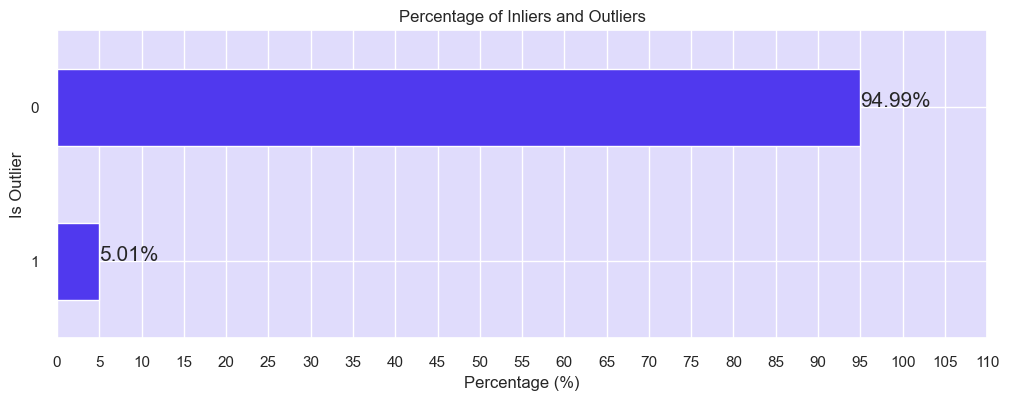

In [180]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#5039ee')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [181]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [182]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape[0]

4018

6 | Correlation Analysis

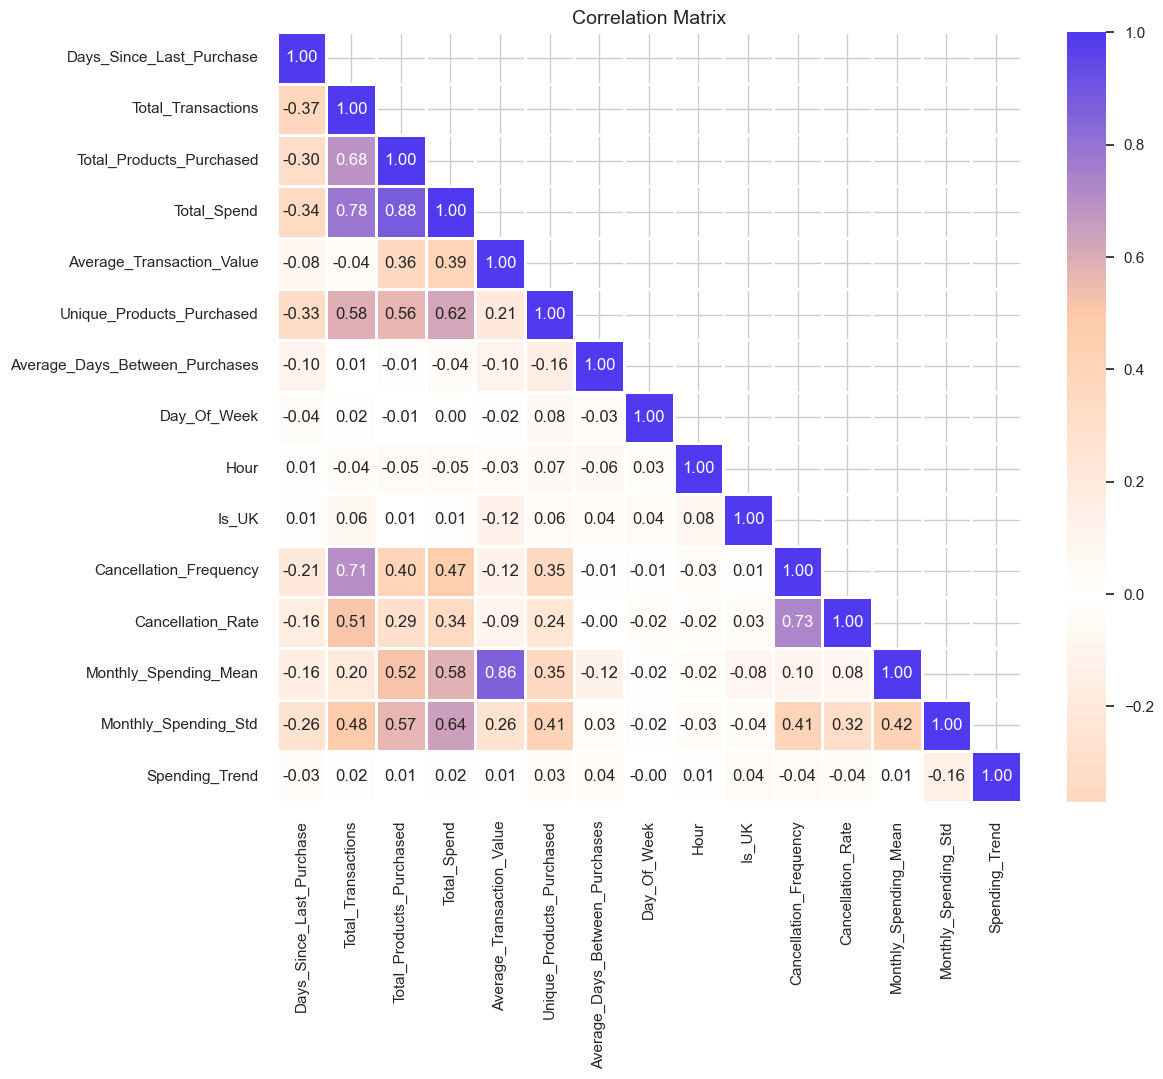

In [183]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'Customer ID' column
corr = customer_data_cleaned.drop(columns=['Customer ID']).corr()

# Define a custom colormap
colors = ['#5039ee', '#ffcaa8', 'white', '#ffcaa8', '#5039ee']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

7 | Feature Scaling

In [184]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['Customer ID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,-0.240246,1.780963,-0.685517,-0.565575,-1.191926,-0.515611,0.648643,0,0.148421,1,0.213574,-0.335786,-1.058020,-0.388445,-0.036683
1,12347.0,-0.906054,-0.534565,0.167991,0.122295,1.876345,0.201621,-0.317546,6,0.586272,0,-0.575883,-0.446319,1.166530,-0.334391,0.631203
2,12348.0,-0.167423,-0.766118,-0.344789,-0.671605,-0.265735,-0.629717,-0.378485,0,0.586272,0,-0.575883,-0.446319,-0.500025,-0.718859,0.066736
3,12349.0,-0.489924,-0.303013,0.345664,0.751610,2.220001,0.543937,-0.014878,3,-2.040837,0,0.213574,-0.004184,1.433898,2.841291,3.379366
4,12351.0,-0.822828,-0.766118,-0.469610,-0.614145,0.122174,-0.597115,-0.378485,0,1.024123,0,-0.575883,-0.446319,-0.198229,-0.718859,0.066736


8 | Dimensionality Reduction

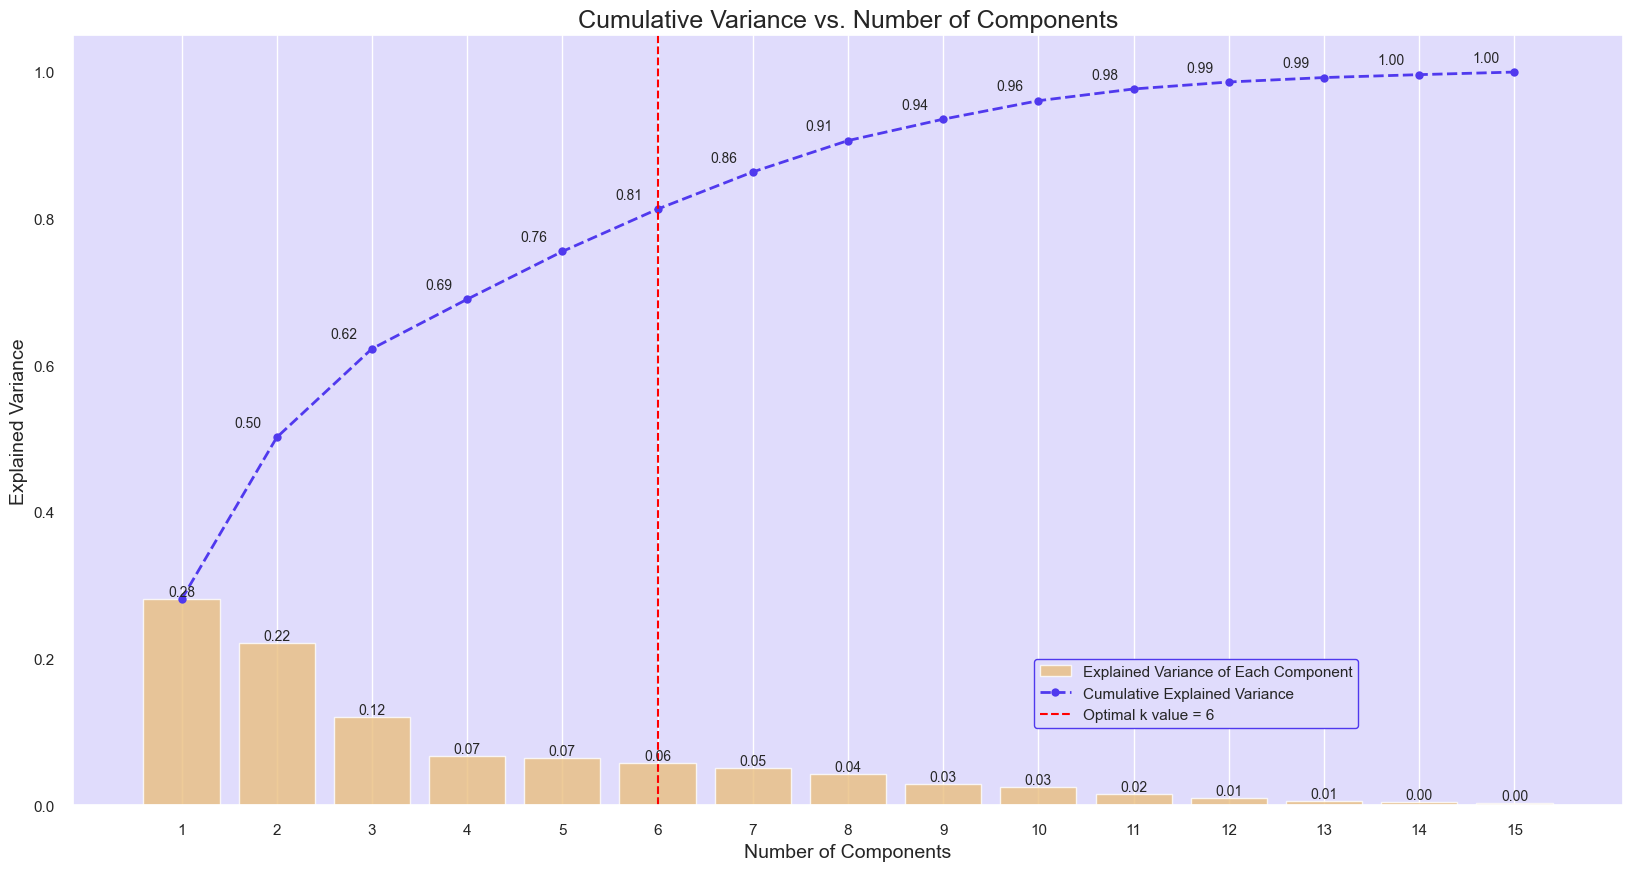

In [185]:
# Setting Customer ID as the index column
customer_data_scaled.set_index('Customer ID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#e0dcfc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#5039ee', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#5039ee')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [186]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the Customer ID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [187]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
Customer ID,,,,,,
12346.0,-0.685059,-2.526181,-1.911418,0.539017,-0.392038,0.489863
12347.0,0.503128,3.382707,2.296660,0.273236,-0.725316,0.099636
12348.0,-1.661831,-2.520021,0.114714,-0.295011,-0.610360,0.378651
12349.0,2.419107,0.209661,2.271188,2.054303,-0.433614,-2.573758
12351.0,-1.399964,-2.512948,0.446640,-0.231265,-0.906991,0.830894


In [188]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.204325,-0.018508,0.059940,-0.374288,0.178192,-0.329565
Total_Transactions,0.382352,-0.000260,-0.268569,0.031272,-0.092191,-0.030436
Total_Products_Purchased,0.396545,-0.017568,0.089709,0.075784,-0.028132,-0.001826
Total_Spend,0.427436,-0.013472,0.079722,0.052717,-0.033262,-0.011513
Average_Transaction_Value,0.173881,-0.023453,0.587599,0.001297,0.091846,-0.056970
Unique_Products_Purchased,0.327214,0.038436,0.019911,-0.102730,-0.277968,0.057988
Average_Days_Between_Purchases,-0.025571,-0.023534,-0.125527,0.725924,0.177210,0.343100
Day_Of_Week,0.026691,0.996963,0.011565,0.016444,0.044179,-0.019388
Hour,-0.018755,0.021633,0.003727,-0.370334,-0.530273,0.636630
Is_UK,0.000234,0.006074,-0.018706,0.000254,-0.024835,0.009576


9 | K-Means Clustering

 9.Determining the Optimal Number of Clusters

9.1.1  Elbow Method

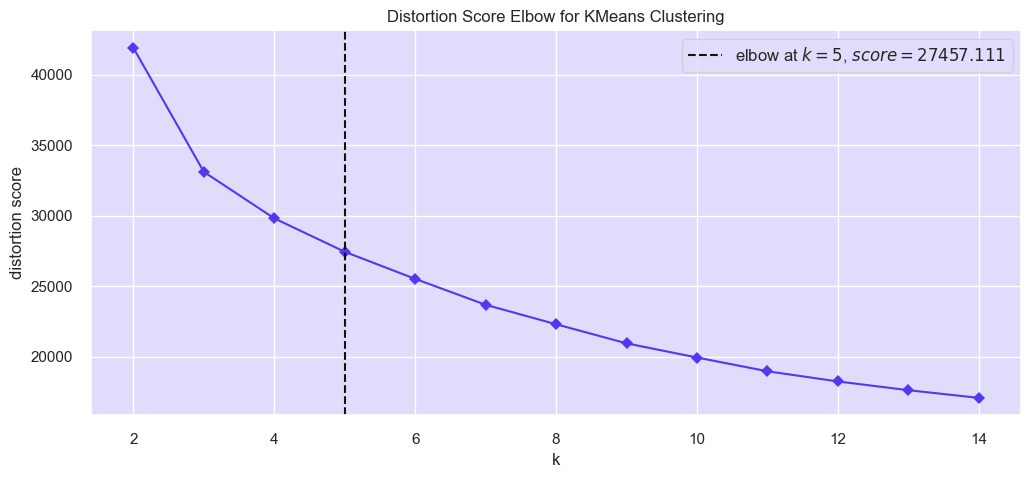

In [189]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#e0dcfc'})

# Set the color palette for the plot
sns.set_palette(['#5039ee'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

9.1.2 Silhouette Method

In [190]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#5039ee', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

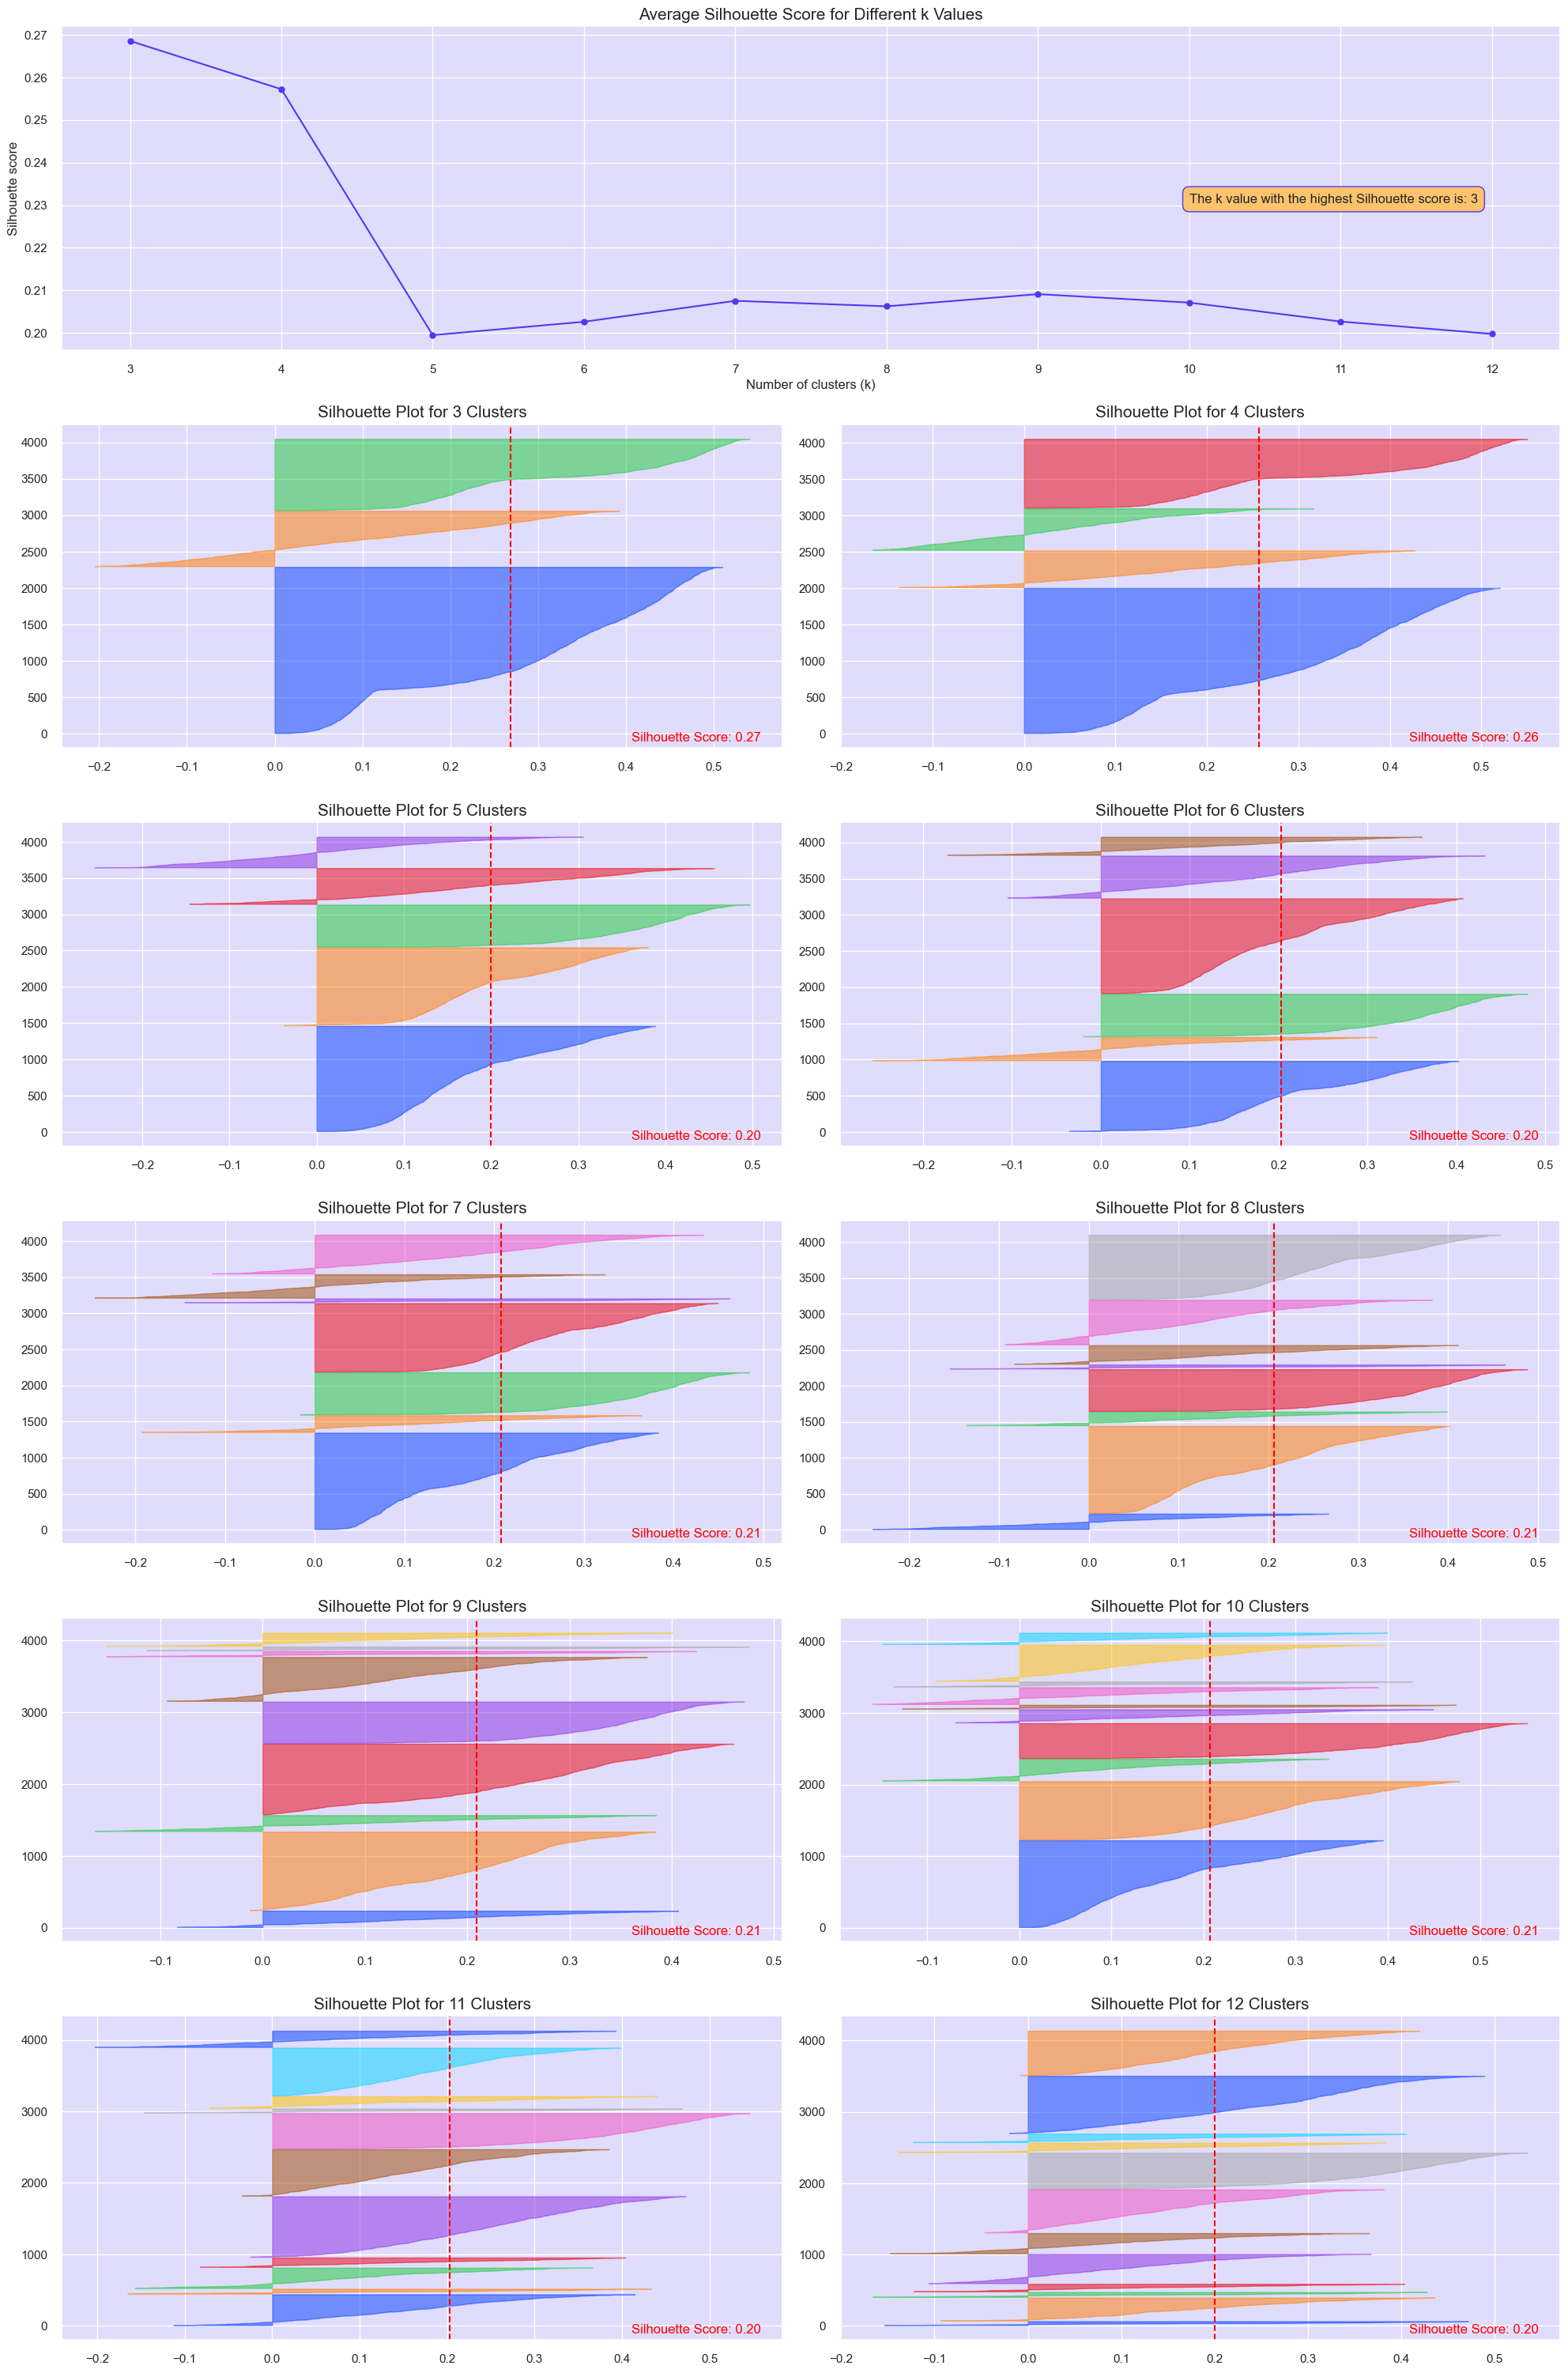

In [191]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

9.2  Clustering Model - K-means

In [192]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [193]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,Customer ID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,66,12,69,368.36,30.696667,26,8.909091,0,13,1,1,0.083333,73.672,60.927253,-18.369,1
1,12347.0,2,2,828,1323.32,661.66,70,0.528571,6,14,0,0,0.0,661.66,70.894526,100.26,0
2,12348.0,73,1,372,221.16,221.16,19,0.0,0,14,0,0,0.0,221.16,0.0,0.0,1
3,12349.0,42,3,986,2196.99,732.33,91,3.153846,3,8,0,1,0.333333,732.33,656.479014,588.385,2
4,12351.0,10,1,261,300.93,300.93,21,0.0,0,15,0,0,0.0,300.93,0.0,0.0,1


10 | Clustering Evaluation

10.1  3D Visualization of Top Principal Components

In [194]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

In [195]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#e0dcfc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#e0dcfc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#e0dcfc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

10.2   Cluster Distribution Visualization

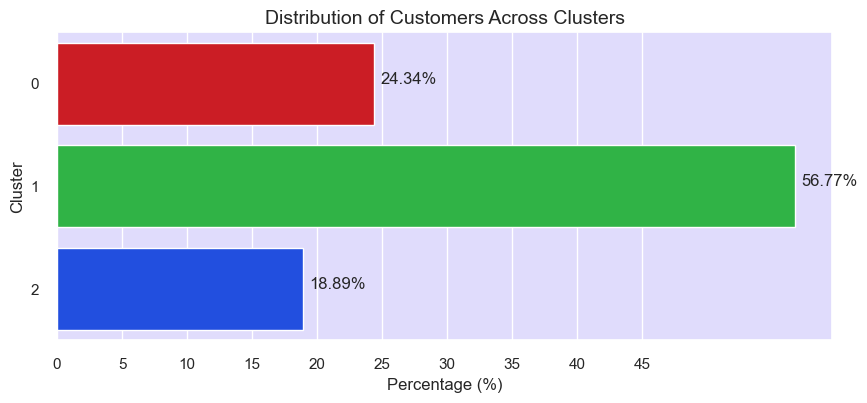

In [196]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

10.3  Evaluation Metrics

In [197]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        4018        |
|    Silhouette Score     | 0.2685579193239155 |
| Calinski Harabasz Score | 1308.7340911112437 |
|  Davies Bouldin Score   | 1.274497821067233  |
+-------------------------+--------------------+


11 | Cluster Analysis and Profiling

 11.1 Radar Chart Approach

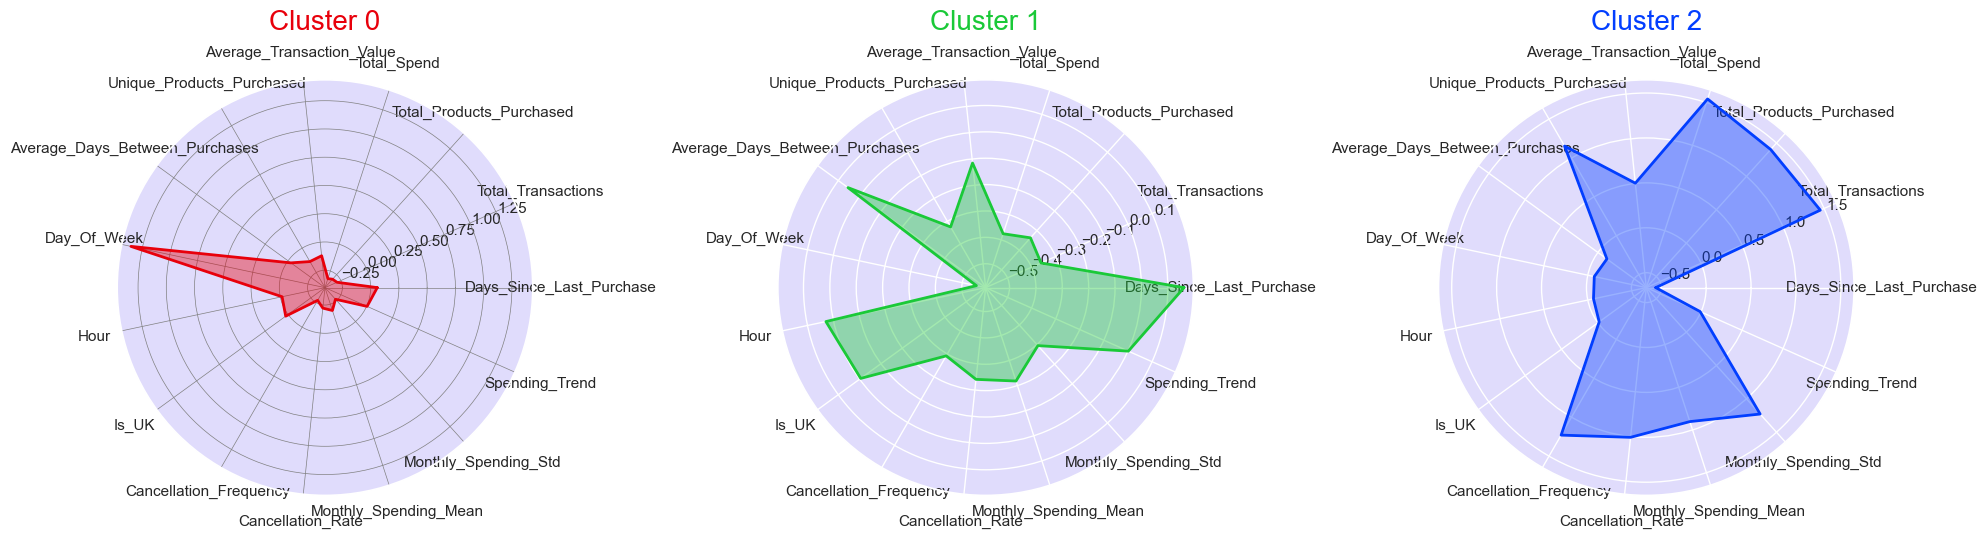

In [198]:
# Setting 'Customer ID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('Customer ID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

Customer Profiles Derived from Radar Chart Analysis
Cluster 0 (Red Chart)

- Customers in this cluster tend to spend less, with a lower number of transactions and products purchased.  
- They have a slight tendency to shop during the weekends, as indicated by the very high `Day_of_Week` value.  
- Their spending trend is relatively stable but on the lower side, and they have a low monthly spending variation (low `Monthly_Spending_Std`).  
- These customers have not engaged in many cancellations, showing a low cancellation frequency and rate.  
- The average transaction value is on the lower side, indicating that when they do shop, they tend to spend less per transaction.  

____
    
Cluster 1 (Green Chart):  
     
- Customers in this cluster show a moderate level of spending, but their transactions are not very frequent, as indicated by the high `Days_Since_Last_Purchase` and `Average_Days_Between_Purchases`.  
- They have a very high spending trend, indicating that their spending has been increasing over time.  
- These customers prefer shopping late in the day, as indicated by the high `Hour` value, and they mainly reside in the UK.  
- They have a tendency to cancel a moderate number of transactions, with a medium cancellation frequency and rate.  
- Their average transaction value is relatively high, meaning that when they shop, they tend to make substantial purchases.  

____
    
Cluster 2 (Blue Chart):
    
- Customers in this cluster are high spenders with a very high total spend, and they purchase a wide variety of unique products.  
- They engage in frequent transactions, but also have a high cancellation frequency and rate.  
- These customers have a very low average time between purchases, and they tend to shop early in the day (low `Hour` value).  
- Their monthly spending shows high variability, indicating that their spending patterns might be less predictable compared to other clusters.  
- Despite their high spending, they show a low spending trend, suggesting that their high spending levels might be decreasing over time.  

11.2 Histogram Chart Approach

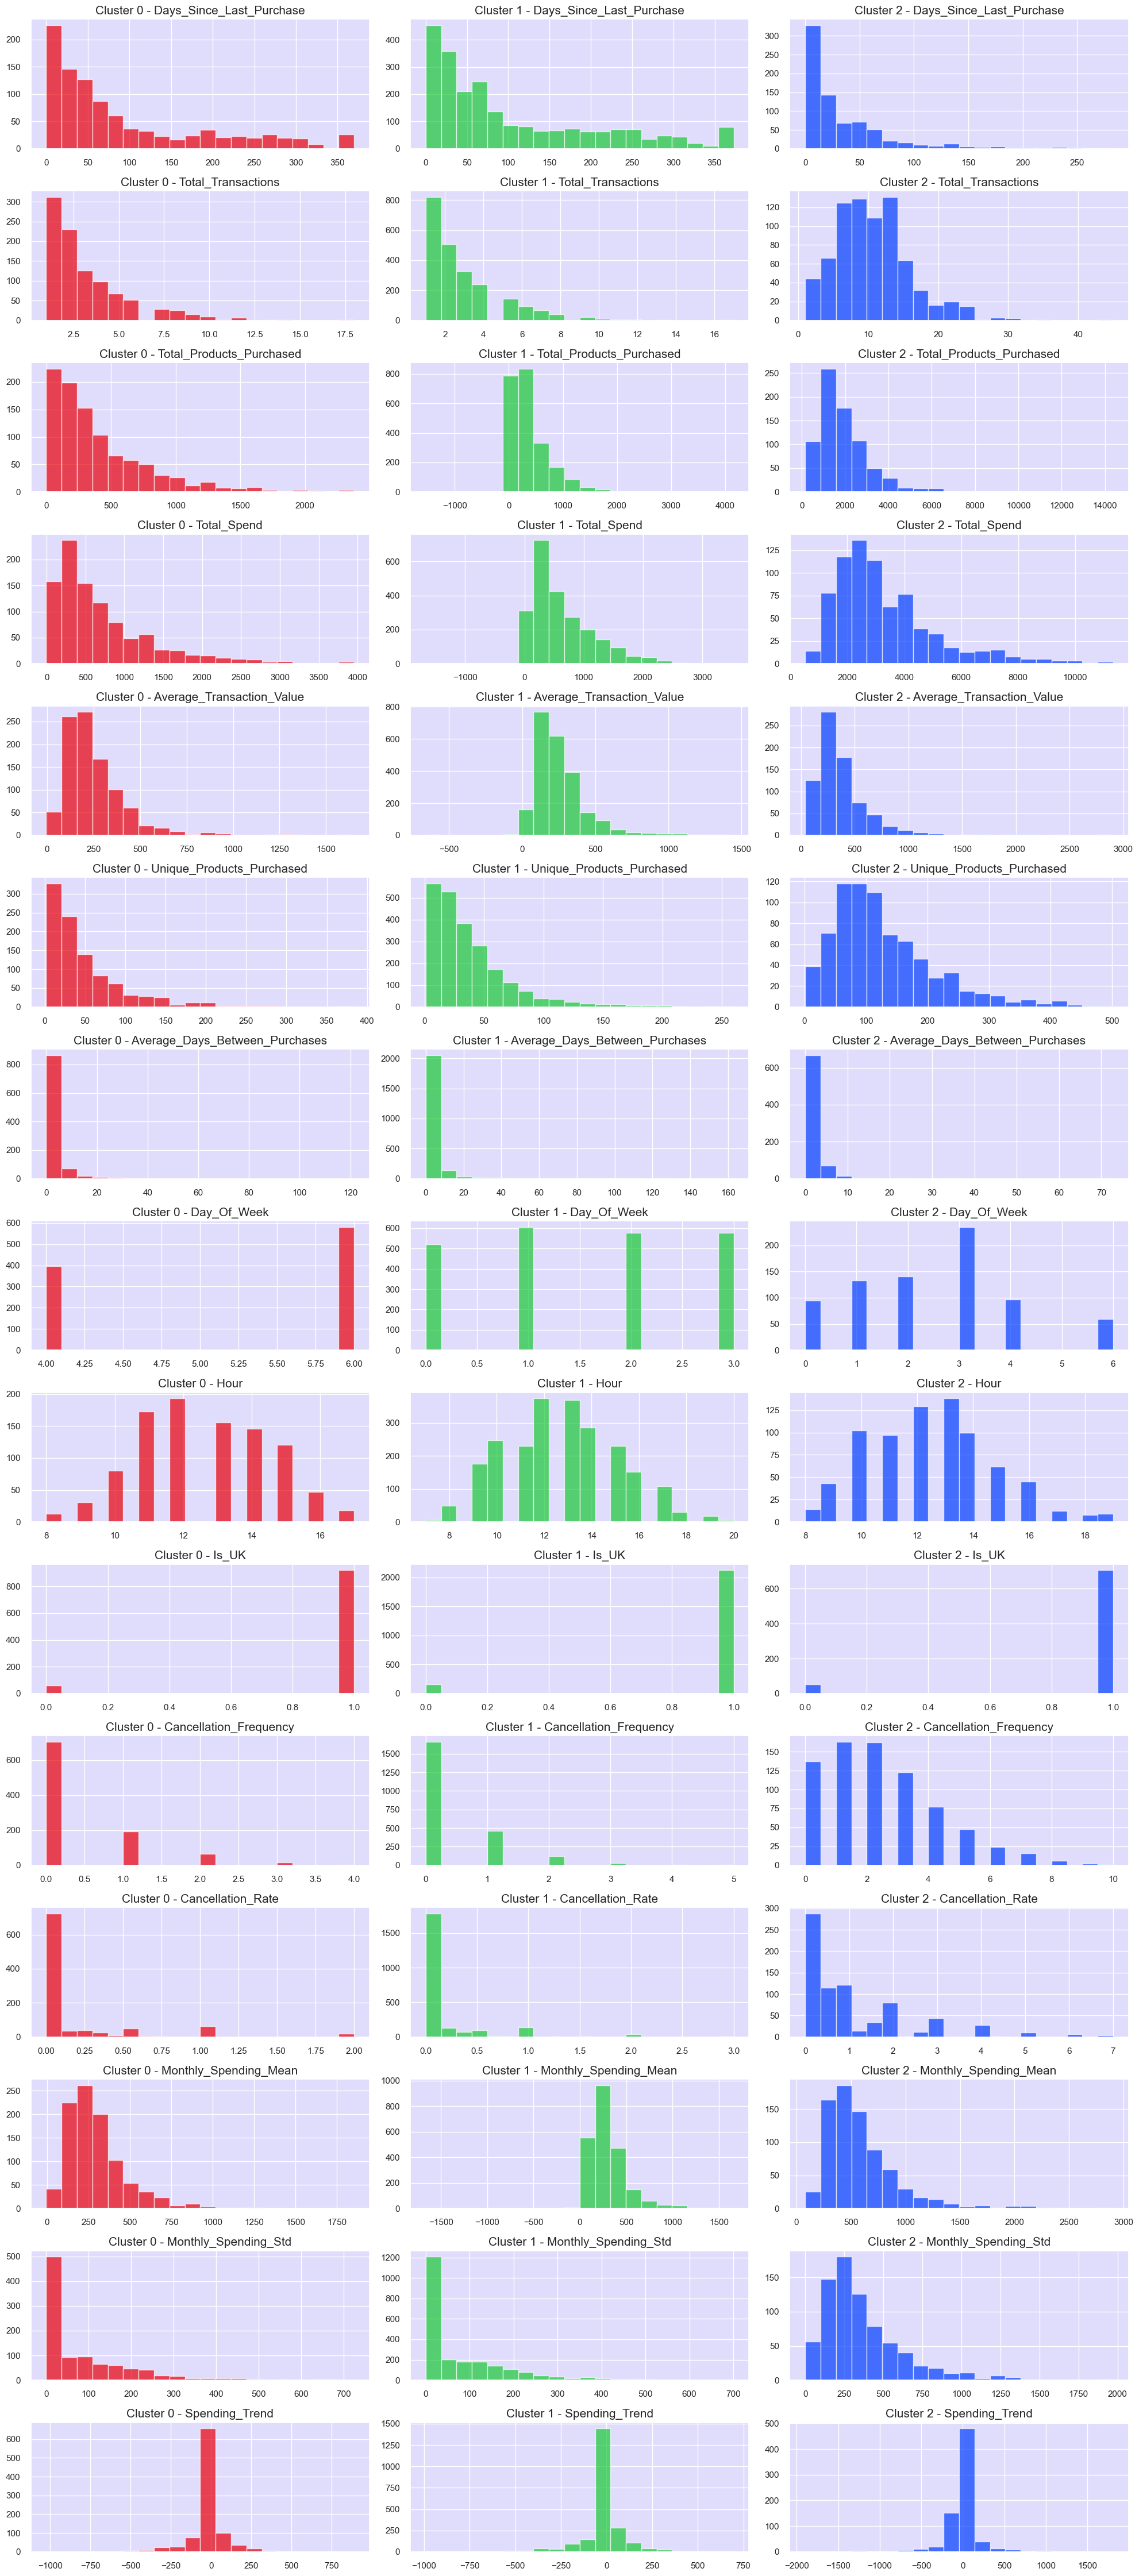

In [199]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

12 | Recommendation System

In [200]:
# Step 1: Extract the Customer IDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['Customer ID'].astype('float').unique()
df_filtered = df[~df['Customer ID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for Customer ID across both dataframes before merging
customer_data_cleaned['Customer ID'] = customer_data_cleaned['Customer ID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['Customer ID', 'cluster']], on='Customer ID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['Customer ID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['Customer ID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['Customer ID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['Customer ID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['Customer ID', 'cluster'], how='right')

In [201]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('Customer ID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
Customer ID,,,,,,
13478.0,84568,GIRLS ALPHABET IRON ON PATCHES,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,21212,PACK OF 72 RETRO SPOT CAKE CASES
13819.0,17003,BROCADE RING PURSE,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
12805.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17003,BROCADE RING PURSE,84879,ASSORTED COLOUR BIRD ORNAMENT
14130.0,17003,BROCADE RING PURSE,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
16440.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17003,BROCADE RING PURSE,84879,ASSORTED COLOUR BIRD ORNAMENT
13900.0,84270,ASSTD DESIGN BUBBLE GUM RING,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84991,60 TEATIME FAIRY CAKE CASES
14843.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17003,BROCADE RING PURSE,84879,ASSORTED COLOUR BIRD ORNAMENT
15956.0,84270,ASSTD DESIGN BUBBLE GUM RING,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84991,60 TEATIME FAIRY CAKE CASES
15674.0,84568,GIRLS ALPHABET IRON ON PATCHES,21212,PACK OF 72 RETRO SPOT CAKE CASES,84598,BOYS ALPHABET IRON ON PATCHES


In [202]:
def get_recommendations_for_customer(customer_id):
    recommendations = []
    for cluster in top_products_per_cluster['cluster'].unique():
        top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
        
        if customer_id in customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['Customer ID'].tolist():
            # Identify products already purchased by the customer
            customer_purchased_products = customer_purchases[(customer_purchases['Customer ID'] == customer_id) & 
                                                             (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
            
            # Find top 3 products in the best-selling list that the customer hasn't purchased yet
            top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
            top_3_products_not_purchased = top_products_not_purchased.head(3)
            
            # Append the recommendations to the list
            recommendations.append([customer_id, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())
    
    # Create a DataFrame from the recommendations list
    recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description',
                                                               'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
    
    return recommendations_df

# Example: Get recommendations for a specific customer (replace 'CUSTOMER_ID_TO_RECOMMEND' with the desired customer ID)
customer_id_to_recommend = 15211# Replace with the desired customer ID
customer_recommendations = get_recommendations_for_customer(customer_id_to_recommend)

print(customer_recommendations)


   CustomerID  cluster  Rec1_StockCode     Rec1_Description  Rec2_StockCode  \
0       15211        1           17003  BROCADE RING PURSE            84879   

                Rec2_Description  Rec3_StockCode           Rec3_Description  
0  ASSORTED COLOUR BIRD ORNAMENT           15036  ASSORTED COLOURS SILK FAN  


In [203]:
merged_data.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Transaction_Status,InvoiceDay,Total_Spend,Day_Of_Week,Hour,Year,Month,cluster
309867,538145,35648,VINTAGE BEAD PINK PURSE,12,2010-12-09 16:08:00,2.95,15211.0,United Kingdom,Completed,2010-12-09,35.40,3,16,2010,12,1
309868,538145,22276,WASH BAG VINTAGE ROSE PAISLEY,6,2010-12-09 16:08:00,2.55,15211.0,United Kingdom,Completed,2010-12-09,15.30,3,16,2010,12,1
309869,538145,82494L,WOODEN FRAME ANTIQUE WHITE,6,2010-12-09 16:08:00,2.95,15211.0,United Kingdom,Completed,2010-12-09,17.70,3,16,2010,12,1
309870,538145,22469,HEART OF WICKER SMALL,12,2010-12-09 16:08:00,1.65,15211.0,United Kingdom,Completed,2010-12-09,19.80,3,16,2010,12,1
309871,538145,21135,VICTORIAN METAL POSTCARD SPRING,8,2010-12-09 16:08:00,1.69,15211.0,United Kingdom,Completed,2010-12-09,13.52,3,16,2010,12,1


In [204]:
def get_recommendations_for_customer(customer_id, num_recommendations=5):
    recommendations = []
    for cluster in top_products_per_cluster['cluster'].unique():
        top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
        
        if customer_id in customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['Customer ID'].tolist():
            # Identify products already purchased by the customer
            customer_purchased_products = customer_purchases[(customer_purchases['Customer ID'] == customer_id) & 
                                                             (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
            
            # Find top products in the best-selling list that the customer hasn't purchased yet
            top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
            
            # Get the specified number of recommendations (num_recommendations)
            top_n_products_not_purchased = top_products_not_purchased.head(num_recommendations)
            
            # Append the recommendations to the list
            recommendations.append([customer_id, cluster] + top_n_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())
    
    # Create a DataFrame from the recommendations list
    recommendations_df = pd.DataFrame(recommendations, columns=['Customer ID', 'cluster'] + \
                                      [f'Rec{i}_StockCode' for i in range(1, num_recommendations + 1)] + \
                                      [f'Rec{i}_Description' for i in range(1, num_recommendations + 1)])
    
    return recommendations_df

# Example: Get 5 recommendations for a specific customer (replace 'CUSTOMER_ID_TO_RECOMMEND' with the desired customer ID)
customer_id_to_recommend = 13085  # Replace with the desired customer ID
num_recommendations = 3  # Specify the number of recommendations
customer_recommendations = get_recommendations_for_customer(customer_id_to_recommend, num_recommendations)

print(customer_recommendations)


   Customer ID  cluster Rec1_StockCode                      Rec2_StockCode  \
0        13085        0         85123A  WHITE HANGING HEART T-LIGHT HOLDER   

   Rec3_StockCode              Rec1_Description  Rec2_Description  \
0           84270  ASSTD DESIGN BUBBLE GUM RING             84077   

                    Rec3_Description  
0  WORLD WAR 2 GLIDERS ASSTD DESIGNS  
